Simple approach to check how it all works.

In [1]:
import csv
import operator

from keras.callbacks import History
from keras.layers import (
    Activation,
    Conv1D,
    Dense,
    Dropout,
    Flatten,
    MaxPooling1D,
)
from keras.models import Sequential
from keras.optimizers import (
    SGD,
    RMSprop,
)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

Using TensorFlow backend.


## Simple preprocessing

In [20]:
decks = pd.read_csv("./data/decks.csv", index_col=0)
games = pd.read_csv("./data/training_games.csv", sep=';', index_col=0)

In [11]:
# Random permutation of games:
games = games.sample(frac=1)

In [13]:
decks['prob'] = [0] * 400
decks['prob'] = decks['prob'].astype('float')

for index, _ in decks.iterrows():
    temp = games.loc[games['Talia1'] == index]
    times_played = temp.shape[0]
    temp = temp.loc[temp['Wynik'] == 'PLAYER_0 WON']
    times_won = temp.shape[0]
    
    temp = games.loc[games['Talia2'] == index]
    times_played = times_played + temp.shape[0]
    temp = temp.loc[temp['Wynik'] == 'PLAYER_1 WON']
    times_won = times_won + temp.shape[0]
    
    decks['prob'][index] = times_won / times_played

/home/kris/PycharmProjects/SUS/lab1/venv/lib/python3.5/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [16]:
bots = ['A1', 'A2', 'B1', 'B2']

for bot in bots:
    decks['prob_' + bot] = [0] * 400
    decks['prob_' + bot] = decks['prob_' + bot].astype('float')
    
    for index, _ in decks.iterrows():
        temp = games.loc[(games['Talia1'] == index) & (games['Gracz1'] == bot)]
        times_played = temp.shape[0]
        temp = temp.loc[temp['Wynik'] == 'PLAYER_0 WON']
        times_won = temp.shape[0]
        
        temp = games.loc[(games['Talia2'] == index) & (games['Gracz1'] == bot)]
        times_played = times_played + temp.shape[0]
        temp = temp.loc[temp['Wynik'] == 'PLAYER_1 WON']
        times_won = times_won + temp.shape[0]
        
        decks['prob_' + bot][index] = times_won/times_played

/home/kris/PycharmProjects/SUS/lab1/venv/lib/python3.5/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [7]:
# Save to be able to access data many times without running preprocessing.
decks.to_csv('./data/adjusted_decks.csv')

In [21]:
# Get example of games
games_100_rows = games.head(100)
games_100_rows.to_csv('./data/games_100_rows.csv')

## Getting and preparing data

In [2]:
decks = pd.read_csv('./data/adjusted_decks.csv', index_col=0)
print(f'There are {decks.shape[0]} decks. Each one is represented as {decks.shape[1]} dimensional vector.\n')
print('This is how it looks like:')
decks.head()

There are 400 decks. Each one is represented as 344 dimensional vector.

This is how it looks like:


,Abyssal Enforcer,Acherus Veteran,Acidic Swamp Ooze,Acolyte of Agony,Acolyte of Pain,Al'Akir the Windlord,Alleycat,Aluneth,Ancestral Healing,Animal Companion,...,Priest,Rogue,Shaman,Warlock,Warrior,prob,prob_A1,prob_A2,prob_B1,prob_B2
deckName,,,,,,,,,,,,,,,,,,,,,
deck252103,0,0,0,0,2,0,0,0,0,0,...,0,0,0,0,1,0.408011,0.402576,0.429119,0.410319,0.391304
deck105300,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0.430965,0.469605,0.430657,0.374684,0.412121
deck822100,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.620577,0.629283,0.609155,0.602469,0.646154
deck829295,0,0,0,0,2,0,0,0,0,0,...,0,0,0,1,0,0.544320,0.567732,0.572414,0.482051,0.548387
deck627915,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0.456177,0.456311,0.481356,0.435616,0.456140


In [3]:
# games = pd.read_csv('./data/training_games.csv', index_col=0)
games = pd.read_csv('./data/games_100_rows.csv', index_col=0)
games.head()

,Gracz1,Talia1,Gracz2,Talia2,Wynik
Id,,,,,
100001.0,A1,deck113225,A1,deck731599,PLAYER_0 WON
100002.0,A1,deck694943,A1,deck929572,PLAYER_1 WON
100003.0,A1,deck182567,A1,deck525929,PLAYER_0 WON
100004.0,A1,deck219364,A1,deck757429,PLAYER_1 WON
100005.0,A1,deck826229,A1,deck337123,PLAYER_1 WON


In [4]:
# Save for later
decks['prob'].to_csv('./data/prob.csv')

/home/kris/Desktop/repair/challenge_project/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


In [5]:
prob = pd.read_csv("./data/prob.csv", index_col=0)

In [6]:
zero_data = np.zeros(shape=(0, 2 * decks.shape[1]))
column_names = 2 * list(decks.columns.values)
X_train = pd.concat([decks.loc[games.loc[i]["Talia1"]].append(decks.loc[games.loc[i]["Talia2"]])
                    for i in range(100001, 100001 + games.shape[0])], axis=1, ignore_index=True)

In [7]:
X_train = X_train.transpose()

In [8]:
dummies_ai1 = pd.get_dummies(games['Gracz1']).reset_index().drop(columns=['Id'])
dummies_ai2 = pd.get_dummies(games['Gracz2']).reset_index().drop(columns=['Id'])
X_train = pd.concat([X_train, dummies_ai1, dummies_ai2], axis=1)

In [9]:
# Save for later
with open('X_train.csv', 'w') as csvfile:
    X_train.head(1000).to_csv(csvfile)

In [10]:
y = games['Wynik']

In [11]:
y_dummies = pd.get_dummies(games['Wynik']).reset_index().drop(columns=['Id'])

In [12]:
with open('y_dummies_train.csv', 'w') as csvfile:
    y_dummies.head(1000).to_csv(csvfile)

In [13]:
y = y.replace(['PLAYER_0 WON', 'PLAYER_1 WON'], [0, 1])
y = y.reset_index().drop(columns=['Id'])

In [14]:
with open('y_train.csv', 'w') as csvfile:
    y.head(1000).to_csv(csvfile)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y, test_size=0.1)

## Naive Bayes

In [17]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)

/home/kris/Desktop/repair/challenge_project/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [18]:
mnb.score(X_test, y_test)

0.5

### Results:

In [59]:
test_decks = pd.read_json('../testDecks.json', lines=True)
test_decks['deckName'] = test_decks['deckName'].apply(operator.itemgetter(0))
test_decks['hero'] = test_decks['hero'].apply(operator.itemgetter(0))
column_names_single = list(decks.columns.values)
zero_data_single = np.zeros(shape=(0, decks.shape[1]))
#result = pd.DataFrame(zero_data_single, columns=column_names_single)
data = [[]]
hero_dict = {'Druid': 330, 'Hunter': 331, 'Mage': 332, 'Paladin': 333, 'Priest': 334, 'Rogue': 335, 'Shaman': 336, 'Warlock': 337, 'Warrior': 338}

for index, row in test_decks.iterrows():
    new_row = []
    
    for card in list(decks.columns):
        if card in row['cards']:
            new_row.append(row['cards'][card][0])
        else:
            new_row.append(0)
            
    new_row[hero_dict[row['hero']]] = 1
            
    data.append(new_row)

data.remove([])
result = pd.DataFrame(data, columns=column_names_single, index=test_decks.loc[:]['deckName'])
print(result.head())

            Abyssal Enforcer  Acherus Veteran  Acidic Swamp Ooze  \
deckName                                                           
deck244804                 0                0                  0   
deck124802                 0                0                  0   
deck687350                 0                0                  0   
deck517728                 0                0                  0   
deck130762                 0                0                  0   

            Acolyte of Agony  Acolyte of Pain  Al'Akir the Windlord  Alleycat  \
deckName                                                                        
deck244804                 0                1                     0         0   
deck124802                 0                2                     0         0   
deck687350                 0                1                     0         0   
deck517728                 0                2                     0         0   
deck130762                 0         

In [ ]:
#all_decks = pd.concat([decks, result], axis=0)
#print(all_decks.head())

In [27]:
bots = ['A1', 'A2', 'B1', 'B2']

with open('results.csv', 'w') as csvfile:
    row_writer = csv.writer(csvfile, delimiter=';', quotechar='|', quoting=csv.QUOTE_MINIMAL)
    
    for bot in bots:
        for j in range(200):
            sum_scores = 0
            
            for i in range(400):
                to_count = pd.concat([result.iloc[j], decks.iloc[i]])
                sum_scores = sum_scores + mnb.predict_proba([to_count])[0][0]
                
            mean = sum_scores / 6
            
            row_writer.writerow([bot, result.index[j], str(round(mean, 1))])

## CNN

In [56]:
batch_size = 128
num_classes = 1
nepochs = 10
learning_rate = 0.03
decay_rate = learning_rate / nepochs

In [57]:
model = Sequential()

model.add(Conv1D(32, 3, padding='same', input_shape=(686, 1), activation='hard_sigmoid'))
model.add(MaxPooling1D(pool_size=2))
#model.add(Dropout(0.1))

model.add(Conv1D(32, 3, padding='same', activation='hard_sigmoid'))
model.add(MaxPooling1D(pool_size=2))
#model.add(Dropout(0.2))

model.add(Conv1D(32, 3, padding='same', activation='hard_sigmoid'))
model.add(MaxPooling1D(pool_size=2))
#model.add(Dropout(0.3))

model.add(Conv1D(32, 3, padding='same', activation='hard_sigmoid'))
model.add(MaxPooling1D(pool_size=2))
#model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(500, activation='hard_sigmoid'))
#model.add(Dropout(0.4))
model.add(Dense(500, activation='hard_sigmoid'))
model.add(Dense(num_classes, activation='sigmoid'))

In [58]:
#opt = RMSprop(lr=0.2)
opt = SGD(lr=learning_rate, momentum=0.9, decay=decay_rate, nesterov=True)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])

In [33]:
X_train_small = np.expand_dims(X_train, axis=2)[0:686, :, :]

In [59]:
X_train_finall = np.expand_dims(X_train, axis=2)

In [47]:
y.head(686).shape

(686,)

In [53]:
train_data = pd.DataFrame(X_train_finall[:, :, 0])

In [61]:
history = model.fit(X_train_finall, y, batch_size=batch_size, epochs=nepochs)

Epoch 1/10
299680/299680 [==============================] - 236s 788us/step - loss: 0.2482 - acc: 0.5476
Epoch 2/10
299680/299680 [==============================] - 243s 812us/step - loss: 0.2477 - acc: 0.5513
Epoch 3/10
299680/299680 [==============================] - 239s 799us/step - loss: 0.2476 - acc: 0.5517
Epoch 4/10
299680/299680 [==============================] - 234s 780us/step - loss: 0.2475 - acc: 0.5517
Epoch 5/10
299680/299680 [==============================] - 237s 790us/step - loss: 0.2475 - acc: 0.5517
Epoch 6/10
 71552/299680 [======>.......................] - ETA: 3:10 - loss: 0.2477 - acc: 0.5494

KeyboardInterrupt: 

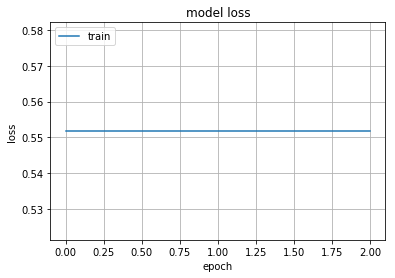

In [91]:
%matplotlib inline 
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.grid()
plt.legend(['train', 'test'], loc='upper left')
plt.title('model loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [81]:
bots = ['A1', 'A2', 'B1', 'B2']
to_count = pd.concat([result.iloc[10], decks.iloc[10], pd.Series([1, 0, 0, 0, 1, 0, 0, 0], index=2*bots)])
print(to_count)
print(to_count.shape)

Abyssal Enforcer        0
Acherus Veteran         0
Acidic Swamp Ooze       0
Acolyte of Agony        2
Acolyte of Pain         0
Al'Akir the Windlord    0
Alleycat                0
Aluneth                 0
Ancestral Healing       0
Animal Companion        0
Annoy-o-Tron            0
Antique Healbot         0
Arcane Blast            0
Arcane Explosion        0
Arcane Giant            0
Arcane Intellect        0
Arcane Missiles         0
Arcane Shot             0
Arcanite Reaper         0
Arcanologist            0
Archmage                0
Archmage Antonidas      0
Argent Commander        0
Argent Horserider       0
Argent Squire           0
Armorsmith              0
Assassin's Blade        0
Assassinate             0
Astral Communion        0
Aya Blackpaw            0
                       ..
Voidwalker              0
Volcanic Potion         0
Volcano                 0
Voodoo Doctor           0
Vulgar Homunculus       0
Warsong Commander       0
Water Elemental         0
Wax Elementa

In [92]:
results = model.predict_proba(np.expand_dims(to_count, axis=1).reshape(1, 686, 1))

In [93]:
print(results)

[[1.]]


Let's try with lower dimensions

In [126]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=25, n_iter=300)
tsne_results = tsne.fit_transform(train_data)

[t-SNE] Computing 76 nearest neighbors...


In [ ]:
from ggplot import *

df_tsne = train_data.copy()
df_tsne['x-tsne'] = tsne_results[:, 0]
df_tsne['y-tsne'] = tsne_results[:, 1]

chart = ggplot(df_tsne, aes(x='x-tsne', y='y-tsne', color='label')) \
        + geom_point(size=70, alpha=0.1) \
        + ggtitle("tSNE dimensions colored by digit")
chart
